In [1]:
# Convolutional Neural Network
 
# Installing Theano
# pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git
 
# Installing Tensorflow
# Install Tensorflow from the website: https://www.tensorflow.org/versions/r0.12/get_started/os_setup.html
 
# Installing Keras
# pip install --upgrade keras

IMAGES_PATH = 'C:/Users/madad/Documents/pets/petfinder-adoption-prediction/train_images/'
RESIZED_IMAGES_PATH = 'C:/Users/madad/Documents/pets/petfinder-adoption-prediction/train_resized/'
CSV_PATH = 'C:/Users/madad/Documents/pets/petfinder-adoption-prediction/train/train.csv'

In [3]:
# Part 1 - Building the Models
 
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

#-----------------------------------------------------------------------------
# Multilayer Perceptron
#-----------------------------------------------------------------------------
def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="relu"))

    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))

    # return our model
    return model

#-----------------------------------------------------------------------------
# Regression-based CNN
#-----------------------------------------------------------------------------
def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # Step 1 - Convolution
        x = Conv2D(f, (3, 3), padding="same")(x)
        
        # Step 2 - RELU
        x = Activation("relu")(x)
        
        # Step 3 - BN
        x = BatchNormalization(axis=chanDim)(x)
        
        # Step 4 - Pooling
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # Step 5 - Flattening
    x = Flatten()(x)
    
    # Step 6 - FC layer
    x = Dense(16)(x)
    
    # Step 7 - RELU
    x = Activation("relu")(x)
    
    # Step 8 - BN
    x = BatchNormalization(axis=chanDim)(x)
    
    # Step 9 - DROPOUT
    x = Dropout(0.5)(x)

    # Step 10 - apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    
    # Step 11 - RELU
    x = Activation("relu")(x)

    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)

    # construct the CNN
    model = Model(inputs, x)
    
    print(model.summary())

    # return the CNN
    return model

Using TensorFlow backend.


In [4]:
# # use this method if your images are not resized
# def resize_image(source_path, dest_path):
#     image = Image.open(source_path).convert('RGB')
#     resized_image = image.resize((IMAGE_SIZE, IMAGE_SIZE))

#     # Uncomment to save to local directory 
#     # Get image name
#     name=os.path.basename(source_path)
#     resized_image.save(dest_path + name, "JPEG")

#     # new_image size (64,64)
#     return np.asarray(resized_image)

# def load_resize_pet_images(df, source, destination):    
#     # initialize images array 
#     images = []
    
#     # loop over the csv rows
#     for index, row in df.iterrows():
        
#         img_source = source + row['PetID'] + '.jpg'
    
#         resized = resize_image(img_source, destination)
        
#         # add the image to the set of images the network will be trained on
#         images.append(resized)
        
#     # return our set of images
#     return np.array(images)

In [7]:
from PIL import Image
import io
import os

IMAGE_SIZE = 64

def read_image(path):
    image = Image.open(path).convert('RGB')
    return np.asarray(image)

def load_pet_images(df, inputDir):    
    # initialize images array 
    images = []

    # loop over the csv rows
    for index, row in df.iterrows():
        
        img_path = inputDir + row['PetID'] + '.jpg'
    
        img = read_image(img_path)
        
        # add the image to the set of images the network will be trained on
        images.append(img)
    
    # return our set of images
    return np.array(images)

In [9]:
import pandas as pd
from random import shuffle
import glob
from PIL import Image
import numpy as np
import re

def process_csv(df):
    new_df = pd.DataFrame() 

    for index, row in df.iterrows():
        
        quantity = int(row['PhotoAmt'])
        
        if (not re.match("^[a-zA-Z0-9_]*$", row['PetID'])):
            print(row['PetID'])
            continue
    
        petId = str(row['PetID'])
        
        for i in range(1, quantity+1):
            new_row = row
            new_row['PetID'] = petId + '-' + str(i)
            
            new_df = new_df.append([new_row],ignore_index=True)
            
    return new_df
    
def load_pet_attributes(inputPath):
    # initialize the list of column names in the CSV file and then
    # load it using Pandas
    cols = ["Type", "Name", "Age", "Breed1", "Breed2", "Gender", "Color1", "Color2", "Color3", "MaturitySize", "FurLength", "Vaccinated", "Dewormed", "Sterilized", "Health", "Quantity", "Fee", "State", "RescuerID", "VideoAmt", "Description", "PetID", "PhotoAmt", "AdoptionSpeed"]
    df = pd.read_csv(inputPath, header=0, usecols=['PhotoAmt', 'PetID', 'AdoptionSpeed'], names=cols)
    
    df = process_csv(df)

    # return the data frame
    return df

In [10]:
#-----------------------------------------------------------------------------
# Load pet features from csv
#-----------------------------------------------------------------------------
# construct the path to the train.csv file that contains information
# on each pet in the dataset and then load the dataset
print("[INFO] loading pet features...")
df = load_pet_attributes(CSV_PATH)
print("[INFO] processed features")

[INFO] loading pet features...
[INFO] processed features


In [11]:
df.head()

,PetID,PhotoAmt,AdoptionSpeed
0,86e1089a3-1,1.0,2
1,6296e909a-1,2.0,0
2,6296e909a-2,2.0,0
3,3422e4906-1,7.0,3
4,3422e4906-2,7.0,3


In [13]:
#-----------------------------------------------------------------------------
# Load the pet images
#-----------------------------------------------------------------------------
# scale the pixel intensities to the range [0, 1]
print("[INFO] loading pet images...")
images = load_pet_images(df, RESIZED_IMAGES_PATH)
images = images / 255.0
print("[INFO] processed images")

[INFO] loading pet images...
[INFO] processed images


In [15]:
#-----------------------------------------------------------------------------
# Split data into training and testing sets
#-----------------------------------------------------------------------------

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import locale

# partition the data into training and testing splits using 90% of
# the data for training and the remaining 10% for testing
split = train_test_split(df, images, test_size=0.1, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [16]:
# Scale the pet adoption speed to the range [0, 1] (will lead to better
# training and convergence)
# the largest pet adoption value is 4 
maxAdoption = 4
trainY = trainAttrX["AdoptionSpeed"] / maxAdoption
testY = testAttrX["AdoptionSpeed"] / maxAdoption

In [17]:
#-----------------------------------------------------------------------------
# Define custom loss functions for regression in Keras 
#-----------------------------------------------------------------------------

# root mean squared error (rmse) for regression
def rmse(y_true, y_pred):
    from keras import backend
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# mean squared error (mse) for regression
def mse(y_true, y_pred):
    from keras import backend
    return backend.mean(backend.square(y_pred - y_true), axis=-1)

# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

In [18]:
from keras.callbacks import EarlyStopping

#-----------------------------------------------------------------------------
# Compile Keras model
#-----------------------------------------------------------------------------
# create the Convolutional Neural Network and then compile the model
# using mean absolute percentage error as loss, implying that we
# seek to minimize the absolute percentage difference between our
# adoption speed *predictions* and the *actual adoption speeds*
model = create_cnn(64, 64, 3, regress=True)
model.compile(optimizer='adam', loss="mean_squared_error", metrics=["mean_squared_error", rmse, r_square])

# train the model
print("[INFO] training model...")
result = model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
          epochs=10, batch_size=32)
print("[INFO] traing finished")

# enable early stopping based on mean_squared_error
earlystopping = EarlyStopping(monitor="mean_squared_error", patience=40, verbose=1, mode='auto')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        448       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0   

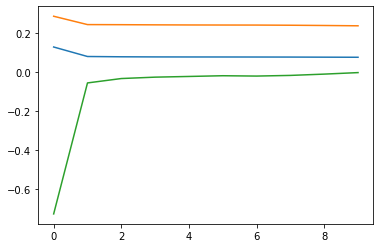

In [22]:
import matplotlib.pyplot as plt

# plot metrics
plt.plot(result.history['mean_squared_error'])
plt.plot(result.history['rmse'])
plt.plot(result.history['r_square'])
plt.show()

In [20]:
def save_model_to_disk(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name + ".h5")
    print("Saved model to disk")

In [21]:
# serialize model
BATCH_SIZE = 32
EPOCHS = 10
IMG_SIZE = 64

model_name = "pets_regression{}pixels_{}epochs".format(IMG_SIZE, EPOCHS)

save_model_to_disk(model)

Saved model to disk
